In [2]:
from dotenv import load_dotenv

load_dotenv("../config/.env")

True

In [3]:
from langchain_neo4j import Neo4jGraph

# 创建数据库连接
neo4j_graph = Neo4jGraph()

movies_query = """
LOAD CSV WITH HEADERS FROM
'https://raw.githubusercontent.com/tomasonjo/blog-datasets/main/movies/movies_small.csv'
AS row
MERGE (m:Movie {id:row.movieId})
SET m.released = date(row.released),
    m.title = row.title,
    m.imdbRating = toFloat(row.imdbRating)
FOREACH (director in split(row.director, '|') |
    MERGE (p:Person {name:trim(director)})
    MERGE (p)-[:DIRECTED]->(m))
FOREACH (actor in split(row.actors, '|') |
    MERGE (p:Person {name:trim(actor)})
    MERGE (p)-[:ACTED_IN]->(m))
FOREACH (genre in split(row.genres, '|') |
    MERGE (g:Genre {name:trim(genre)})
    MERGE (m)-[:IN_GENRE]->(g))
"""

neo4j_graph.query(movies_query)

[]

In [4]:
neo4j_graph.refresh_schema()
print(neo4j_graph.schema)

Node properties:
Movie {id: STRING, released: DATE, title: STRING, imdbRating: FLOAT}
Person {name: STRING}
Genre {name: STRING}
Relationship properties:

The relationships:
(:Movie)-[:IN_GENRE]->(:Genre)
(:Person)-[:DIRECTED]->(:Movie)
(:Person)-[:ACTED_IN]->(:Movie)


In [5]:
enhanced_graph = Neo4jGraph(enhanced_schema=True)
print(enhanced_graph.schema)

Node properties:
- **Movie**
  - `id`: STRING Example: "1"
  - `released`: DATE Min: 1964-12-16, Max: 1996-09-15
  - `title`: STRING Example: "Toy Story"
  - `imdbRating`: FLOAT Min: 2.4, Max: 9.3
- **Person**
  - `name`: STRING Example: "John Lasseter"
- **Genre**
  - `name`: STRING Example: "Adventure"
Relationship properties:

The relationships:
(:Movie)-[:IN_GENRE]->(:Genre)
(:Person)-[:DIRECTED]->(:Movie)
(:Person)-[:ACTED_IN]->(:Movie)


In [6]:
from langchain.chat_models import init_chat_model
from langchain_neo4j import GraphCypherQAChain

llm = init_chat_model(
    "deepseek-chat",
    model_provider="deepseek",
    temperature=0,
)
chain = GraphCypherQAChain.from_llm(
    graph=enhanced_graph,
    llm=llm,
    verbose=True,
    allow_dangerous_requests=True,
)
response = chain.invoke({"query": "Casino 的演员有哪些"})
response



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (:Movie {title: "Casino"})<-[:ACTED_IN]-(actor:Person)
RETURN actor.name;
Full Context:
[{'actor.name': 'Robert De Niro'}, {'actor.name': 'Joe Pesci'}, {'actor.name': 'Sharon Stone'}, {'actor.name': 'James Woods'}]

> Finished chain.


{'query': 'Casino 的演员有哪些',
 'result': '《Casino》的主要演员包括罗伯特·德尼罗、乔·佩西、莎朗·斯通和詹姆斯·伍兹。'}

In [7]:
from operator import add
from typing import Annotated, List, Literal
from typing_extensions import TypedDict

class InputState(TypedDict):
    question: str

class OverallState(TypedDict):
    question: str
    next_action: str
    cypher_statement: str
    cypher_errors: List[str]
    database_records: List[dict]
    steps: Annotated[List[str], add]

class OutputState(TypedDict):
    answer: str
    steps: List[str]
    cypher_statement: str

def guardrails_condition(
    state: OverallState
) -> Literal["generate_cypher", "generate_final_answer"]:
    if state.get("next_action") == "end":
        return "generate_final_answer"
    else:
        return "generate_cypher"

def validate_cypher_condition(
    state: OverallState
) -> Literal["generate_final_answer", "execute_cypher", "correct_cypher"]:
    if state.get("next_action") == "end":
        return "generate_final_answer"
    elif state.get("next_action") == "execute_cypher":
        return "execute_cypher"
    else:
        return "correct_cypher"

In [8]:
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate

guardrails_system = """
作为一名智能助手，你的主要目标是判断给定的问题是否与电影相关。如果该问题与电影相关，输出“movie”；否则，输出“end”。
为做出这一判断，需评估问题的内容，确定其是否涉及任何电影、演员、导演、电影行业或相关话题。仅提供指定的输出：“movie”或“end”。
"""
guardrails_prompt = ChatPromptTemplate(
    [
        ("system", guardrails_system),
        ("human", "{question}")
    ]
)

class GuardrailsOutput(BaseModel):
    decision: Literal["movie", "end"] = Field(description="关于该问题是否与电影相关的决定")

guardrails_chain = guardrails_prompt | llm.with_structured_output(GuardrailsOutput)

def guardrails(state: InputState):
    """判断该问题是否与电影相关。"""

    guardrails_output = guardrails_chain.invoke({"question": state["question"]})
    database_records = (
        "这个问题与电影及其演员无关。因此，我无法回答这个问题。"
        if guardrails_output.decision == "end"
        else None
    )

    return {
        "next_action": guardrails_output.decision,
        "database_records": database_records,
        "steps": ["guardrail"],
    }

In [10]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.example_selectors import SemanticSimilarityExampleSelector
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_neo4j import Neo4jVector

embeddings = HuggingFaceEmbeddings(model_name="Qwen/Qwen3-Embedding-0.6B")

examples = [
    {
        "question": "有多少位演员？",
        "query": "MATCH (a:Person)-[:ACTED_IN]->(:Movie) RETURN count(DISTINCT a)",
    },
    {
        "question": "哪些演员出演了电影《赌城风云》？",
        "query": "MATCH (m:Movie {title: 'Casino'})<-[:ACTED_IN]-(a) RETURN a.name",
    },
    {
        "question": "汤姆·汉克斯出演了多少部电影？",
        "query": "MATCH (a:Person {name: 'Tom Hanks'})-[:ACTED_IN]->(m:Movie) RETURN count(m)",
    },
    {
        "question": "列出电影《辛德勒的名单》的所有类型",
        "query": "MATCH (m:Movie {title: 'Schindler's List'})-[:IN_GENRE]->(g:Genre) RETURN g.name",
    },
    {
        "question": "哪些演员同时出演过喜剧和动作类电影？",
        "query": "MATCH (a:Person)-[:ACTED_IN]->(:Movie)-[:IN_GENRE]->(g1:Genre), (a)-[:ACTED_IN]->(:Movie)-[:IN_GENRE]->(g2:Genre) WHERE g1.name = 'Comedy' AND g2.name = 'Action' RETURN DISTINCT a.name",
    },
    {
        "question": "哪些导演执导的电影中至少有三位名叫'John'的不同演员？",
        "query": "MATCH (d:Person)-[:DIRECTED]->(m:Movie)<-[:ACTED_IN]-(a:Person) WHERE a.name STARTS WITH 'John' WITH d, COUNT(DISTINCT a) AS JohnsCount WHERE JohnsCount >= 3 RETURN d.name",
    },
    {
        "question": "找出导演也在片中出演的电影",
        "query": "MATCH (p:Person)-[:DIRECTED]->(m:Movie), (p)-[:ACTED_IN]->(m) RETURN m.title, p.name",
    },
    {
        "question": "找出数据库中出演电影数量最多的演员",
        "query": "MATCH (a:Actor)-[:ACTED_IN]->(m:Movie) RETURN a.name, COUNT(m) AS movieCount ORDER BY movieCount DESC LIMIT 1",
    },
]
example_selector = SemanticSimilarityExampleSelector.from_examples(
    examples,
    embeddings,
    Neo4jVector,
    k=5,
    input_keys=["question"]
)

text2cypher_prompt = ChatPromptTemplate(
    [
        (
            "system",
            (
                "给定一个输入问题，将其转换为Cypher查询。无需前言。"
                "不要用任何反引号或其他东西包裹响应。只返回Cypher语句！"
            ),
        ),
        (
            "human",
            (
                """
你是一名 Neo4j 专家。给定一个输入问题，创建一个语法正确的 Cypher 查询来运行。
不要用任何反引号或其他东西包裹响应。只返回 Cypher 语句！
以下是模式信息
{schema}
以下是一些问题及其对应的 Cypher 查询示例。
{fewshot_examples}
用户输入：{question}
Cypher 查询：
                """
            ),
        ),
    ]
)

text2cypher_chain = text2cypher_prompt | llm | StrOutputParser()

def generate_cypher(state: OverallState) -> OverallState:
    """基于提供的模式和用户输入生成一个Cypher语句"""

    fewshot_examples = "\n\n".join(
        [
            f"用户输入：{el['question']}\nCypher 查询：{el['query']}"
            for el in example_selector.select_examples({"question": state.get("question")})
        ]
    )
    generated_cypher = text2cypher_chain.invoke(
        {
            "question": state.get("question"),
            "fewshot_examples": fewshot_examples,
            "schema": enhanced_graph.schema
        }
    )

    return {
        "cypher_statement": generated_cypher,
        "steps": ["generate_cypher"],
    }

In [28]:
from typing import Optional
from langchain_neo4j.chains.graph_qa.cypher_utils import CypherQueryCorrector, Schema
from neo4j.exceptions import CypherSyntaxError

validate_cypher_system = "你是一名密码专家，正在审阅一位初级开发人员编写的语句。"
validate_cypher_user = """
你必须检查以下内容：
Cypher 语句中是否存在任何语法错误？
Cypher 语句中是否有任何缺失或未定义的变量？
模式中是否缺少任何节点标签？
模式中是否缺少任何关系类型？
是否有任何属性未包含在模式中？
Cypher 语句是否包含足够的信息来回答该问题？
良好错误示例：
Label（:Foo）不存在，您是不是想说（:Bar）？
Property Foo 没有属性 bar，您是不是想说 baz？
Relationship FOO 不存在，您是不是想说 FOO_BAR？
模式：
{schema}
问题是：
{question}
Cypher 语句是：
{cypher}
请确保不要出错！
"""
validate_cypher_prompt = ChatPromptTemplate(
    [
        ("system", validate_cypher_system),
        ("human", validate_cypher_user)
    ]
)

class Property(BaseModel):
    """表示基于Cypher语句中图形里特定节点属性的过滤条件。"""

    node_label: str = Field(description="此属性所属节点的标签。")
    property_key: str = Field(description="被过滤属性的键。")
    property_value: Optional[str] = Field(description="该属性要匹配的值。")

class ValidateCypherOutput(BaseModel):
    """表示 Cypher 查询输出的验证结果，包括任何错误和应用的过滤器。"""

    errors: Optional[List[str]] = Field(
        description="Cypher 语句中的语法或语义错误列表。务必解释模式与 Cypher 语句之间的不一致之处"
    )
    filters: Optional[List[Property]] = Field(description="Cypher语句中应用的一系列基于属性的过滤器。")

validate_cypher_chain = validate_cypher_prompt | llm.with_structured_output(
    ValidateCypherOutput
)
corrector_schema = [
    Schema(el["start"], el["type"], el["end"])
    for el in enhanced_graph.structured_schema.get("relationships")
]
cypher_query_corrector = CypherQueryCorrector(corrector_schema)

def validate_cypher(state: OverallState) -> OverallState:
    """验证Cypher语句，并将所有属性值映射到数据库。"""

    errors = []
    mapping_errors = []

    try:
        enhanced_graph.query(f"EXPLAIN {state.get('cypher_statement')}")
    except CypherSyntaxError as e:
        errors.append(e.message)

    corrected_cypher = cypher_query_corrector(state.get("cypher_statement"))
    if not corrected_cypher:
        errors.append("生成的Cypher语句不符合图形模式")
    if not corrected_cypher == state.get("cypher_statement"):
        print("关系方向已更正")

    llm_output = validate_cypher_chain.invoke(
        {
            "question": state.get("question"),
            "schema": enhanced_graph.schema,
            "cypher": state.get("cypher_statement")
        }
    )
    if llm_output.errors:
        errors.extend(llm_output.errors)
    if llm_output.filters:
        for filter in llm_output.filters:
            if filter.property_value is None:
                continue

            if (
                not [
                    prop
                    for prop in enhanced_graph.structured_schema["node_props"][filter.node_label]
                    if prop["property"] == filter.property_key
                ][0]["type"] == "STRING"
            ):
                continue

            mapping = enhanced_graph.query(
                f"MATCH (n:{filter.node_label}) WHERE toLower(n.`{filter.property_key}`) = toLower($value) RETURN 'yes' LIMIT 1",
                {"value": filter.property_value},
            )
            if not mapping:
                not_mapping_error_message = f"{filter.node_label} 在属性 {filter.property_key} 上、值为 {filter.property_value} 时的缺失值映射"
                print(not_mapping_error_message)
                mapping_errors.append(not_mapping_error_message)

    if mapping_errors:
        next_action = "end"
    elif errors:
        next_action = "correct_cypher"
    else:
        next_action = "execute_cypher"

    return {
        "next_action": next_action,
        "cypher_statement": corrected_cypher,
        "cypher_errors": errors,
        "steps": ["validate_cypher"],
    }

In [29]:
correct_cypher_prompt = ChatPromptTemplate(
    [
        (
            "system",
            (
                "你是一名密码专家，正在审阅一名初级开发人员编写的语句。"
                "你需要根据所提供的错误来修正密码语句。无需开场白。"
                "不要用任何反引号或其他东西包裹回应。只回应密码语句！"
            ),
        ),
        (
            "human",
            (
                """
检查无效的语法或语义，并返回修正后的Cypher语句。
模式：
{schema}
注意：回复中不要包含任何解释或道歉。
不要用任何反引号或其他东西包裹回复。
只回复Cypher语句！
对于任何不要求你构建Cypher语句的问题，都不要回复。
问题是：
{question}
Cypher语句是：
{cypher}
错误是：
{errors}
修正后的Cypher语句：
                """
            )
        )
    ]
)

correct_cypher_chain = correct_cypher_prompt | llm | StrOutputParser()

def correct_cypher(state: OverallState) -> OverallState:
    """根据提供的错误修正Cypher语句。"""

    corrected_cypher = correct_cypher_chain.invoke(
        {
            "question": state.get("question"),
            "cypher": state.get("cypher_statement"),
            "errors": state.get("cypher_errors"),
            "schema": enhanced_graph.schema,
        }
    )

    return {
        "next_action": "validate_cypher",
        "cypher_statement": corrected_cypher,
        "steps": ["correct_cypher"]
    }

In [30]:
def execute_cypher(state: OverallState) -> OverallState:
    """执行给定的Cypher语句。"""

    records = enhanced_graph.query(state.get("cypher_statement"))
    no_results = "我在数据库中找不到任何相关信息"

    return {
        "database_records": records if records else no_results,
        "steps": ["execute_cypher"],
    }

In [31]:
generate_final_prompt = ChatPromptTemplate(
    [
        ("system", "你是一个乐于助人的助手"),
        (
            "human",
            (
                """
请使用从数据库中检索到的以下结果，对用户的问题给出简洁、明确的答案。直接以回答问题的方式进行回应。
结果：{results}
问题：{question}
                """
            )
        )
    ]
)

generate_final_chain = generate_final_prompt | llm | StrOutputParser()

def generate_final_answer(state: OverallState) -> OutputState:
    """根据数据库结果生成最终答案"""

    final_answer = generate_final_chain.invoke(
        {
            "question": state.get("question"),
            "results": state.get("database_records"),
        }
    )

    return {
        "answer": final_answer,
        "steps": ["generate_final_answer"],
    }

In [32]:
from langgraph.graph import StateGraph, START, END

graph = StateGraph(OverallState, input_schema=InputState, output_schema=OutputState)
graph.add_node(guardrails)
graph.add_node(generate_cypher)
graph.add_node(validate_cypher)
graph.add_node(correct_cypher)
graph.add_node(execute_cypher)
graph.add_node(generate_final_answer)

graph.add_edge(START, "guardrails")
graph.add_conditional_edges("guardrails", guardrails_condition)
graph.add_edge("generate_cypher", "validate_cypher")
graph.add_conditional_edges("validate_cypher", validate_cypher_condition)
graph.add_edge("correct_cypher", "validate_cypher")
graph.add_edge("execute_cypher", "generate_final_answer")
graph.add_edge("generate_final_answer", END)

graph = graph.compile()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


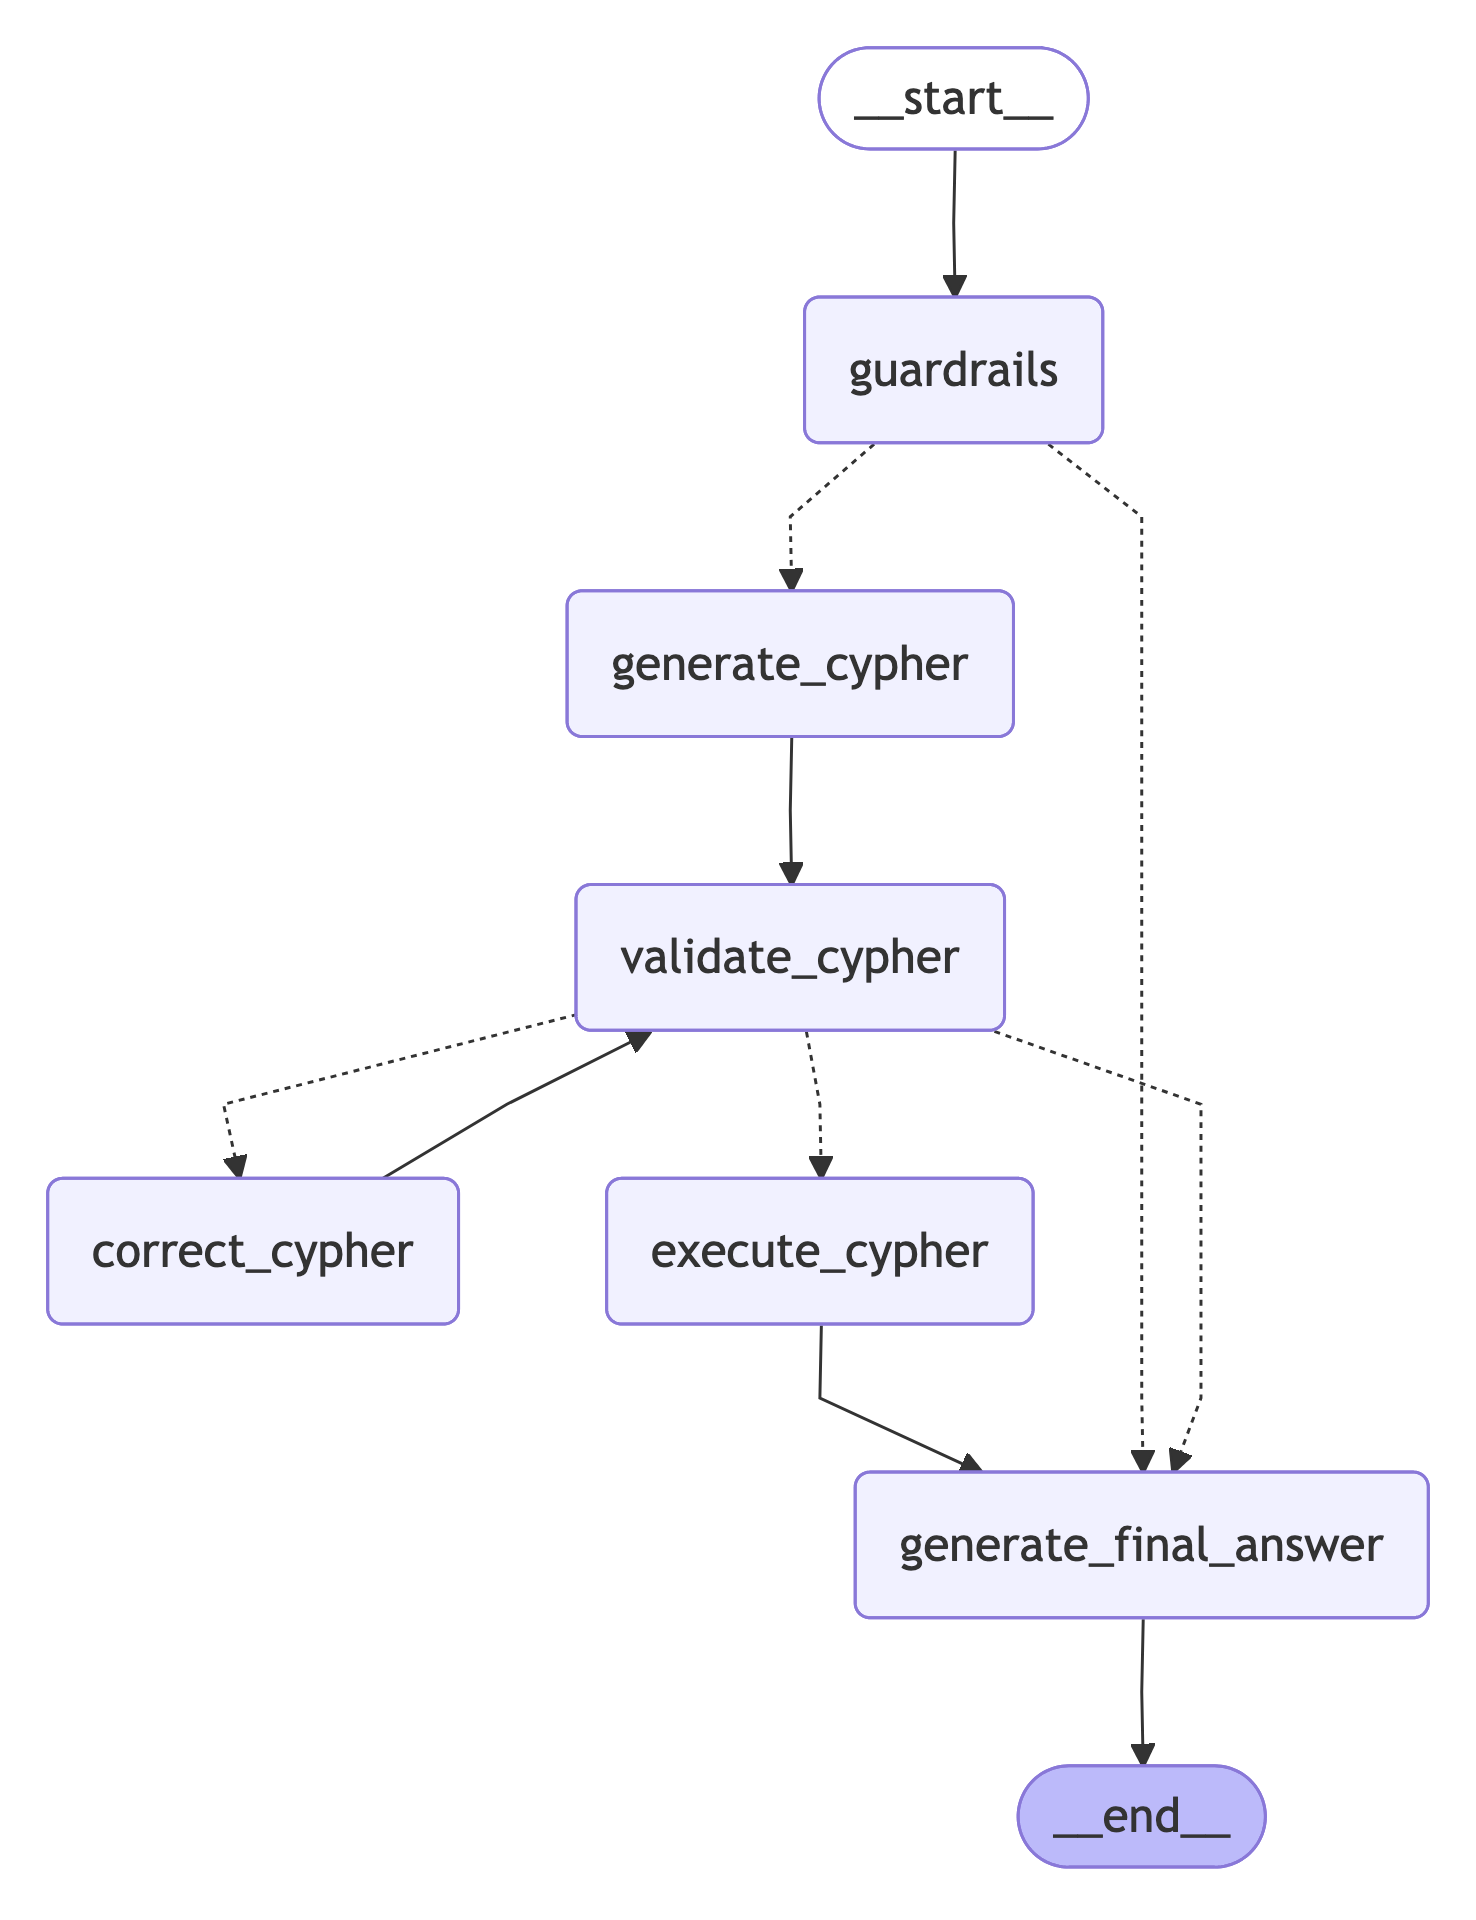

In [18]:
import nest_asyncio
from IPython.display import display, Image
from langchain_core.runnables.graph_mermaid import MermaidDrawMethod

nest_asyncio.apply()
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))

In [19]:
graph.invoke({"question": "今天北京的天气怎么样？"})

{'answer': '根据检索结果，这个问题与电影及其演员无关，因此我无法回答。',
 'steps': ['guardrail', 'generate_final_answer']}

In [33]:
graph.invoke({"question": "Casino 的演员有哪些？"})

{'answer': '《Casino》的演员包括 Robert De Niro、Joe Pesci、Sharon Stone 和 James Woods。',
 'steps': ['guardrail',
  'generate_cypher',
  'validate_cypher',
  'execute_cypher',
  'generate_final_answer'],
 'cypher_statement': "MATCH (m:Movie {title: 'Casino'})<-[:ACTED_IN]-(a:Person) RETURN a.name"}